In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import os
import pprint

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [54]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine, func, inspect, desc\
,MetaData, Table, Column, ForeignKey, Date\
,Integer, String, Float, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [174]:
# inspector = inspect(engine)
# schema = inspector.get_columns("measurement")
# pprint.pprint(schema)

In [11]:
# schema = inspector.get_columns("station")
# pprint.pprint(schema)

In [152]:
#Find the latest date in the db

session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23')

In [14]:
#Find the date from latest date to one year ago
year_ago = dt.date(2017,8,23) - relativedelta(years = 1)
print(year_ago)

2016-08-23


In [15]:
# Extract 1 year of measurements

In [157]:
measurements_one_year = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date >= year_ago).all()

In [17]:
# df = pd.read_sql_query(session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs)\
# .filter(Measurement.date >= year_ago).all().statement,engine)

In [24]:
#Create dataframe from one year of measurements using only prcp and date
prcp_df = pd.DataFrame.from_records(measurements_one_year)
prcp_df.columns = ["date","precipitation"]
prcp_df.set_index("date", inplace = True) 
#sort dataframe by date
prcp_df.sort_values(by='date')
prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [25]:
#Read station data table as dataframe
station_df = pd.read_sql_table("station", con=engine)

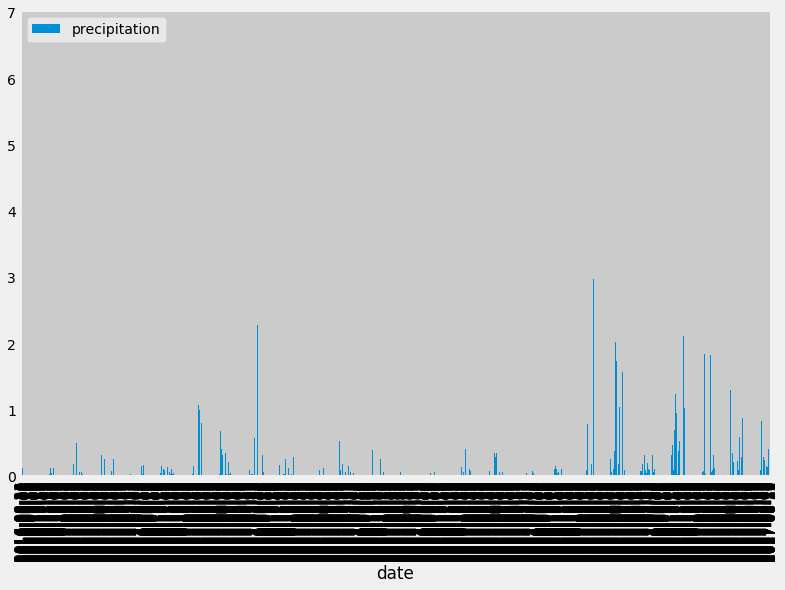

In [35]:
#Plot data using pandas

prcp_df.plot(kind='bar', figsize=(12,8))

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [28]:
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [74]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(distinct(Measurement.station))).all()

[(9)]

In [138]:
# What are the most active stations? (i.e. what stations have the most rows)?
(session.query(Measurement.station, func.count(Measurement.station).label("# counts"))\
.group_by(Measurement.station)).order_by(desc("# counts")).first()

('USC00519281', 2772)

In [137]:
# List the stations and the counts in descending order.
(session.query(Measurement.station, func.count(Measurement.station).label("# counts"))\
.group_by(Measurement.station)).order_by(desc("# counts")).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [109]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station
              , func.min(Measurement.tobs).label("t_min")
              , func.max(Measurement.tobs).label("t_max")
              , func.avg(Measurement.tobs).label("t_avg"))\
                .filter(Measurement.station =="USC00519281")\
                .all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [142]:
# Choose the station with the highest number of temperature observations.
(session.query(Measurement.station, func.count(Measurement.tobs).label("#_t_counts"))\
.group_by(Measurement.station)).order_by(desc("#_t_counts")).first()

('USC00519281', 2772)

In [151]:
# Determine last date entry for USC00519281
session.query(Measurement.date).filter(Measurement.station == "USC00519281")\
.order_by(Measurement.date.desc()).first()

('2017-08-18')

In [153]:
#Find the date from latest date to one year ago
year_ago = dt.date(2017,8,18) - relativedelta(years = 1)
print(year_ago)

2016-08-18


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2CC4E34C8>]],
      dtype=object)

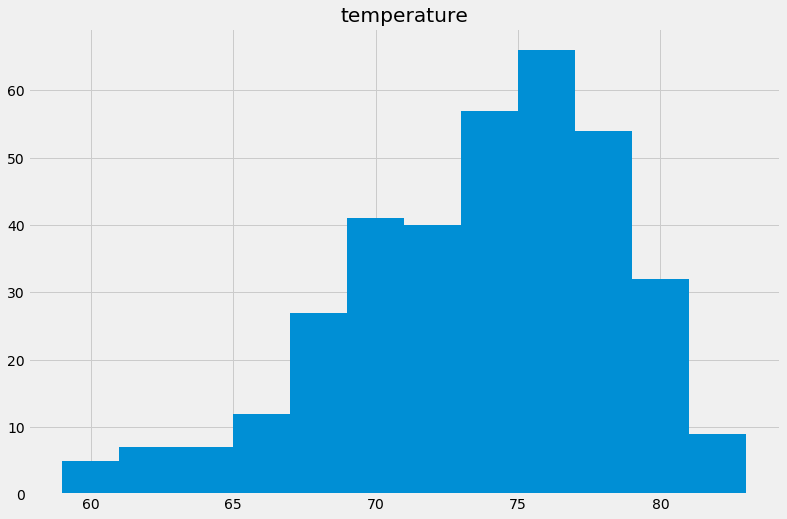

In [173]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs = session.query(Measurement.date
              , Measurement.tobs)\
                .filter(Measurement.station =="USC00519281")\
                .filter(Measurement.date >= year_ago).all()
temp_df = pd.DataFrame.from_records(temp_obs)
temp_df.columns = ["date","temperature"]
temp_df.set_index("date", inplace = True) 

#Plot observations as histgram
temp_df.hist(column = "temperature", figsize=(12,8), bins = 12)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`